<a href="https://colab.research.google.com/github/PatriciaLucas/CNN/blob/master/Notebook_EnsembleCNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference evapotranspiration forecast with CNN1 Ensemble

  


In [1]:
!pip install keras-tcn==2.8.3
!git clone https://github.com/PatriciaLucas/CNN
from CNN import Ensemble_CNN as eCNN
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

Cloning into 'CNN'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 132 (delta 72), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (132/132), 1.24 MiB | 6.40 MiB/s, done.
Resolving deltas: 100% (72/72), done.


Using TensorFlow backend.


##Reference evapotranpiration database

In [0]:
def get_search_dataset():
    df1 = pd.read_csv('https://raw.githubusercontent.com/PatriciaLucas/Evapotranspiracao/master/ETo_setelagoas.csv', sep=',')
    series = df1.iloc[:,1]
    train = series[:6939]
    test = series[8035:] #ano de teste: 2015
    return train, test

train, test = get_search_dataset()

##Using the Ensemble CNN1 model to predict reference evapotranspiration


In [0]:
model = eCNN.Ensemble_CNN(type_models='CNN1', number= 6) #Creating the ensemble with 6 CNN1 models
model.generate_models()         #Generates CNN models

In [22]:
model.fit(data = train.values) #Treina os modelos CNN

Epoch 00086: early stopping
Epoch 00086: early stopping
Epoch 00093: early stopping
Epoch 00096: early stopping


####Point forecast for 5 days ahead

In [23]:
yhat, y_test,_ = model.point_forecast(data = test.values, forecast_horizon=5)
rmse, mae, mape = model.metrics(yhat = yhat, y_test=y_test, forecast_horizon=5)
print("RMSE", rmse)
print("MAE",mae)
print("MAPE",mape)

RMSE [0.7790646912445364, 0.8573351011509384, 0.9043426330390233, 0.9337833957907492, 0.954889591330473]
MAE [0.5972954558261668, 0.6655741750809803, 0.7064486661596868, 0.7317801357090036, 0.7464186941409111]
MAPE [17.161229917585608, 18.553233046800916, 19.32648214889639, 19.804966036900638, 20.050410957871648]


####Probabilistic forecast for 5 days ahead

In [0]:
kde_list, y_test = model.probabilistic_forecast(data = test.values, forecast_horizon=5)

##Horizon forecast confidence interval 1

Text(0, 0.5, 'ETo')

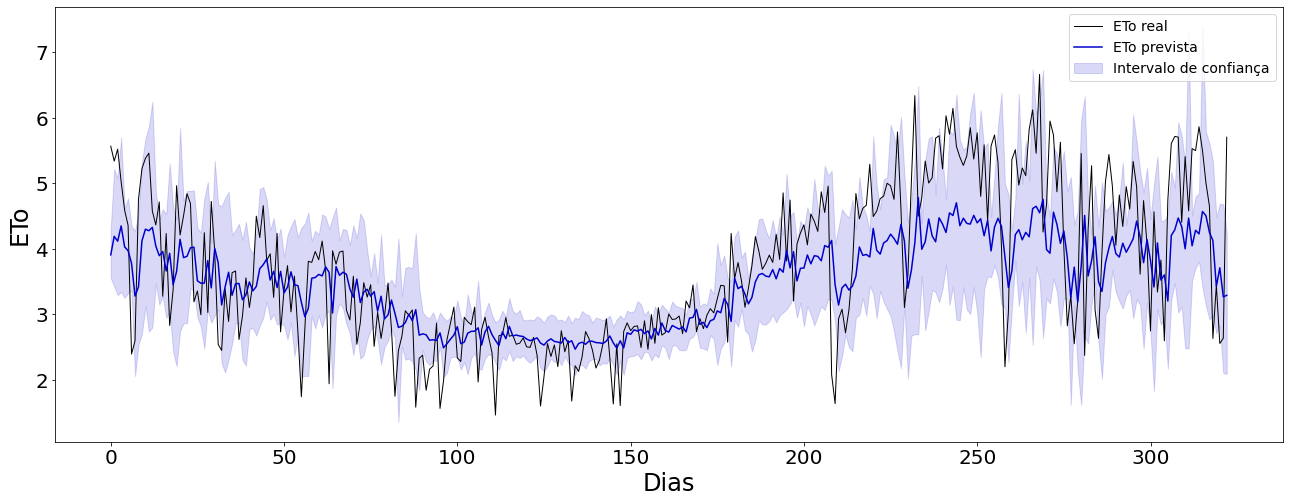

In [26]:
y_hat_CNN = np.zeros((len(y_test),100))
y_mean = np.zeros((len(y_test)))
y_max = np.zeros((len(y_test)))
y_min = np.zeros((len(y_test)))
x = np.zeros((len(y_test)))
for i in range(len(y_test)):
    y = kde_list[0][i].sample(100)
    y_mean[i] = y.mean()
    y_max[i] = y.max()
    y_min[i] = y.min()
    y_hat_CNN[i,:] = y.reshape(1,-1)
    x[i] = i

fig, ax = plt.subplots(figsize=[22,8])
plt.grid(False)
plt.plot(x,y_test,'-', color = 'black', ms=4, lw=1, alpha=1, label='ETo real')
plt.plot(x,y_mean,'-', color = 'mediumblue', ms=4, lw=1, alpha=1, label='ETo prevista',linewidth=1.5)
ax.fill_between(x, y_min, y_max, color='mediumblue', alpha=0.15, label='Intervalo de confiança')
plt.tick_params(labelsize=20)
plt.legend(fontsize=14)
plt.xlabel("Dias", fontsize=24)
plt.ylabel("ETo", fontsize=24)

##Analysis of residues for the forecast horizon 1

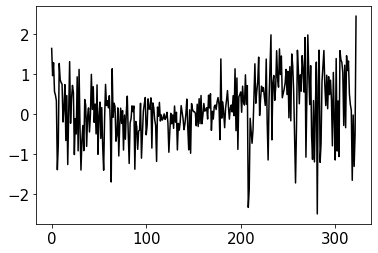

In [27]:
residuals = y_test - yhat[:,0]
plt.plot(x,residuals,'-', color = 'black', ms=4, lw=1, alpha=1, linewidth=1.5)
plt.tick_params(labelsize=15)

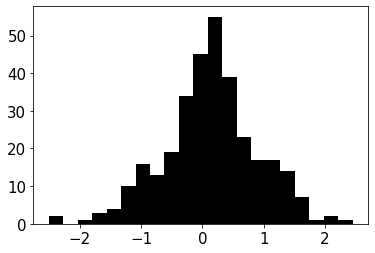

In [28]:
plt.hist(residuals, bins='auto', color='black')
plt.tick_params(labelsize=15)

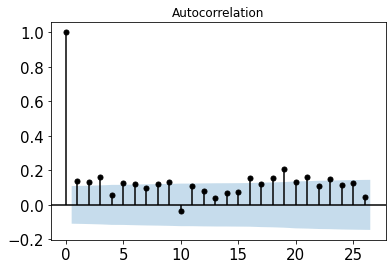

In [29]:
plot_acf(residuals, plt.gca(), color='black', )
plt.tick_params(labelsize=15)

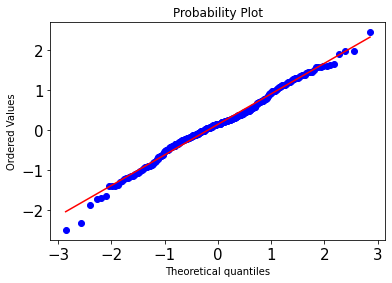

In [30]:
stats.probplot(np.reshape(residuals, (-1)), dist=stats.norm, plot=plt)
plt.tick_params(labelsize=15)
plt.show()